# Map-Reduce

## Plan

1. **Ask the user** what kind of companies they want to invest in and how many options they want to see.
2. **Find some matching stocks** based on the user’s interests.
3. **In parallel**, gather key information about each stock — like financial reports, market performance, etc. (*This is the “map” step.*)
4. **Analyze all the results** and create a final list that (*This is the “reduce” step.*):
- Describes each stock
- Explains why it’s a good investment
- Ranks them by priority

In [1]:
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
import operator
from typing import Annotated

class InvestmentAdvisorState(TypedDict):
    financial_area: str
    stock_number: int
    stock_tickers: list[str]
    stock_details: Annotated[list, operator.add]
    recommendation: str

llm = ChatOpenAI(model="gpt-4o-mini")

## Nodes

### Generate list of stocks

In [2]:
from pydantic import BaseModel

class StockTickers(BaseModel):
    stock_tickers: list[str]

def generate_list_of_stocks(state: InvestmentAdvisorState):
    prompt = f"""
    You are an experienced financial analyst. 
    Based on current market trends and public data, suggest the top {state["stock_number"]} publicly traded companies in the area of "{state["financial_area"]}".

    Return only a list of their stock tickers (symbols), without any explanations.
    """
    
    response = llm.with_structured_output(StockTickers).invoke(prompt)
    return {"stock_tickers": response.stock_tickers}

In [3]:
generate_list_of_stocks({
   "financial_area": "small AI companies",
   "stock_number": 5
})

{'stock_tickers': ['AI', 'C3.ai', 'BILL', 'PLTR', 'RLTY']}

### Fetch Stock Details (Map Step)

see that we do not have to follow here overall graph state structure!

In [4]:
import yfinance as yf

class StockState(TypedDict):
    ticker: str

def fetch_stock_details(state: StockState):
    period = "1mo"
    stock_symbol = state["ticker"]
    try:
        stock = yf.Ticker(stock_symbol)

        # Retrieve general stock info and historical market data
        stock_info = stock.info  # Basic company and stock data
        stock_history = stock.history(period=period).to_dict()  # Historical OHLCV data

        # Combine both into a single dictionary
        stock = {
            "stock_symbol": stock_symbol,
            "info": stock_info,
            "history": stock_history
        }
        
        return {"stock_details": [str(stock)]}
        
    except Exception as e:
        return {"error": f"Error fetching stock data for {stock_symbol}: {str(e)}"}


In [5]:
data = fetch_stock_details({
    "ticker": "AI"
})
print(data)

{'stock_details': ['{\'stock_symbol\': \'AI\', \'info\': {\'address1\': \'1400 Seaport Boulevard\', \'city\': \'Redwood City\', \'state\': \'CA\', \'zip\': \'94063\', \'country\': \'United States\', \'phone\': \'650 503 2200\', \'website\': \'https://www.c3.ai\', \'industry\': \'Software - Infrastructure\', \'industryKey\': \'software-infrastructure\', \'industryDisp\': \'Software - Infrastructure\', \'sector\': \'Technology\', \'sectorKey\': \'technology\', \'sectorDisp\': \'Technology\', \'longBusinessSummary\': "C3.ai, Inc. operates as an enterprise artificial intelligence (AI) application software company in North America, Europe, the Middle East, Africa, the Asia Pacific, and internationally. The company provides C3 agentic AI platform, an application development and runtime environment that enables customers to design, develop, and deploy enterprise AI applications; C3 AI CRM Suite, an industry specific customer relationship management solution; C3 Generative AI that enables to l

### Analyze all the results (Reduce Step)

In [6]:
from langchain_core.messages import HumanMessage

def generate_stock_recommendations(state: InvestmentAdvisorState):
    financial_data = "\n\n\n".join(state["stock_details"])

    prompt = f"""
    You are a professional investment advisor.

    Below is a list of companies with their financial data:

    {financial_data}

    Your task is to:
    1. Analyze each company based on the provided technical information (consider only companies from the list above).
    2. Write a short paragraph for each company that includes:
    - The company name and ticker
    - A brief description
    - Why it may or may not be a good investment
    3. Rank the companies from best to worst in terms of investment potential.
    4. Return the result as a sorted list (highest priority first), where each item includes:
    - Rank (starting from 1)
    - Ticker
    - Company name
    - Short description
    - Reason for its ranking
    """

    recommendation = llm.invoke([HumanMessage(content=prompt)])

    return {"recommendation": recommendation.content}

### Mapping (Fetch Stock Details)

### Compile

C:\Users\jenny\AppData\Local\Temp\ipykernel_38236\4252921073.py:15: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


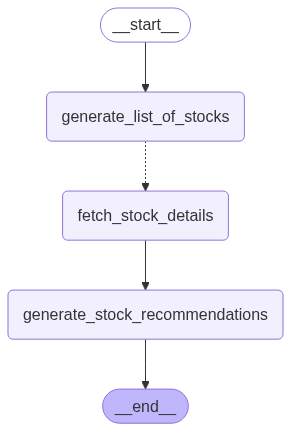

In [7]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

builder = StateGraph(InvestmentAdvisorState)

builder.add_node("generate_list_of_stocks", generate_list_of_stocks)
builder.add_node("fetch_stock_details", fetch_stock_details)
builder.add_node("generate_stock_recommendations", generate_stock_recommendations)


builder.add_edge(START, "generate_list_of_stocks")


# Map - Reducing
from langgraph.constants import Send
def continue_to_details(state: InvestmentAdvisorState):
    return [Send("fetch_stock_details", {"ticker": ticker}) for ticker in state["stock_tickers"]]

builder.add_conditional_edges("generate_list_of_stocks", continue_to_details, ["fetch_stock_details"])



builder.add_edge("fetch_stock_details", "generate_stock_recommendations")
builder.add_edge("generate_stock_recommendations", END)

graph = builder.compile()
Image(graph.get_graph().draw_mermaid_png())

In [8]:
result = graph.invoke({"financial_area": "small AI companies", "stock_number": 5})
result

{'financial_area': 'small AI companies',
 'stock_number': 5,
 'stock_tickers': ['NVDA', 'AMD', 'AI', 'PATH', 'SNOW'],
 'stock_details': ['{\'stock_symbol\': \'NVDA\', \'info\': {\'address1\': \'2788 San Tomas Expressway\', \'city\': \'Santa Clara\', \'state\': \'CA\', \'zip\': \'95051\', \'country\': \'United States\', \'phone\': \'408 486 2000\', \'website\': \'https://www.nvidia.com\', \'industry\': \'Semiconductors\', \'industryKey\': \'semiconductors\', \'industryDisp\': \'Semiconductors\', \'sector\': \'Technology\', \'sectorKey\': \'technology\', \'sectorDisp\': \'Technology\', \'longBusinessSummary\': "NVIDIA Corporation, a computing infrastructure company, provides graphics and compute and networking solutions in the United States, Singapore, Taiwan, China, Hong Kong, and internationally. The Compute & Networking segment includes its Data Centre accelerated computing platforms and artificial intelligence solutions and software; networking; automotive platforms and autonomous an

In [9]:
print(result["recommendation"])

### Investment Analysis and Ranking

1. **Rank: 1**
   - **Ticker:** NVDA
   - **Company Name:** NVIDIA Corporation
   - **Short Description:** NVIDIA is a leading semiconductor company focused on graphics processing units (GPUs) for gaming and professional visualization, as well as AI and data center solutions.
   - **Reason for Ranking:** NVIDIA showcases strong revenue growth (69.2% year-on-year), significant profit margins (51.7%), and an impressive market cap of $4.4 trillion. Its diverse product line and solid presence in gaming and AI sectors promise robust future earnings potential. Despite a high trailing P/E ratio (58.21), the "strong buy" analyst rating indicates confidence in the company's growth trajectory.

2. **Rank: 2**
   - **Ticker:** SNOW
   - **Company Name:** Snowflake Inc.
   - **Short Description:** Snowflake is a cloud-based data platform offering data solutions across various industries. It helps organizations consolidate data and leverage AI for insights.
   -